We need the iso8601 module, unfortunately, to do robust date parsing.

In [3]:
import collections
import csv
import datetime
import json
import glob
import os
import codecs

import iso8601

Specify the folder in which the JSON log files are kept. They will be read and concatenated.

In [240]:
def level_playtimes_for(folder):
    events = []
    filenames = glob.glob(os.path.join(folder, "*.json"))
    filenames.sort()

    for filename in filenames:
        with open(filename, encoding="utf-8-sig") as f:
            if "static" in filename: # Add 'static' if file was downloaded locally, not generated by the node.js server.
                txt = f.read()
                es = json.loads(txt)
                for e in es:
                    events.append( {"0":e[0], "1":e[1]} )
            else:
                for line in f:
                    events.append(json.loads(line))

    tasks = [event for event in events if event["0"] in ("startTask", "endTask")]
    last_level = tasks[-1]["1"]["quest_id"]
    if tasks[-1]["0"] != "endTask":
        for event in events[::-1]:
            if event["1"].get("quest_id") == last_level:
                fake_task = event.copy()
                fake_task["0"] = "endTask"
                tasks.append(fake_task)
                break

    completion_times = collections.defaultdict(list)
    start_times = {}
    for task in tasks:
        if task["0"] == "startTask":
            quest_id = task["1"]["quest_id"]
            if quest_id in start_times:
                print("Task", quest_id, "already has a start time.")
            if "timestamp" in task:
                start_times[quest_id] = iso8601.parse_date(task["timestamp"])
            else:
                start_times[quest_id] = datetime.datetime.fromtimestamp(task["1"]["client_timestamp"] / 1000)
        elif task["0"] == "endTask":
            quest_id = task["1"]["quest_id"]
            start_time = start_times.get(quest_id)
            if not start_time:
                print("WARNING: Level", quest_id, "does not have a start time.")
                continue
            if "timestamp" in task:
                end_time = iso8601.parse_date(task["timestamp"])
            else:
                end_time = datetime.datetime.fromtimestamp(task["1"]["client_timestamp"] / 1000)
            completion_times[quest_id].append((end_time - start_time).total_seconds())
            del start_times[quest_id]

    total_times = {}
    for level_id, times in completion_times.items():
        total_times[level_id] = sum(times)
    total_times[0] = 0

    return [total_times[t] / 60.0 for t in total_times]

def avg_playtime(times):
    avgs = []
    for i in range(min([len(t) for t in times])):
        avgs.append( sum([t[i] for t in times]) / len(times) )
    return avgs

In [241]:
p2 = level_playtimes_for("userlogs/p2")
p3 = level_playtimes_for("userlogs/p3")
p4 = level_playtimes_for("userlogs/p4")
p5 = level_playtimes_for("userlogs/p5")
p6 = level_playtimes_for("userlogs/p6")
p7 = level_playtimes_for("userlogs/p7")
blocks_conditions = [ p3, p4, p6, p7 ]
ct_conditions =     [ p2, p5 ]

Task 57 already has a start time.
Task 65 already has a start time.
Task 66 already has a start time.
Task 6 already has a start time.
Task 41 already has a start time.
Task 66 already has a start time.
Task 2 already has a start time.
Task 2 already has a start time.
Task 6 already has a start time.
Task 34 already has a start time.
Task 60 already has a start time.
Task 25 already has a start time.


We need to synthesize an endTask for the last level, since normally this is only recorded on level transitions.

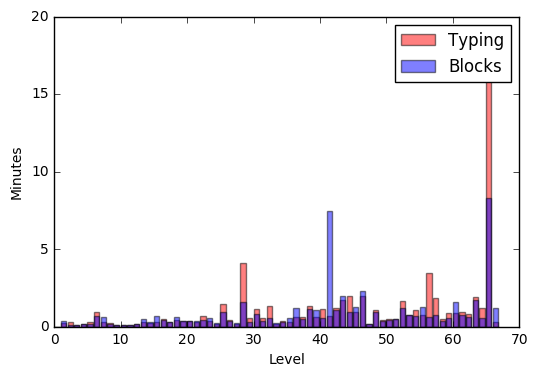

In [256]:
# Plot level playtimes in a bar graph:
import matplotlib.pyplot as plt
blocks_avg = avg_playtime(blocks_conditions)
ct_avg     = avg_playtime(ct_conditions)
ct_plot = plt.bar(range(len(ct_avg)), ct_avg, color='r', alpha=0.5)
blocks_plot = plt.bar(range(len(blocks_avg)), blocks_avg, alpha=0.5)
plt.legend([ct_plot, blocks_plot], ['Typing', 'Blocks'])
plt.xlabel('Level')
plt.ylabel('Minutes')
plt.show()

output_path = os.path.join(folder, "output.csv")
with open(output_path, "w") as output_file:
    writer = csv.writer(output_file)
    for level_id, total_seconds in sorted(total_times.items(), key=lambda x: x[0]):
        writer.writerow((level_id, "{:.02f}".format(total_seconds)))

In [26]:
from IPython.display import FileLink
FileLink(output_path)

/Users/ianarawjo/Desktop/lambda_calc/analysis/userlogs/lauren/output.csv